# Building Fashion Image Classifier with PyTorch: From Basic to CNN Models

## Introduction
In this tutorial, we'll walk through building and comparing three different neural network architectures for classifying fashion items using the Fashion MNIST dataset. We'll start with a simple linear model and progressively move to more complex architectures, explaining each step along the way.

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [57]:
# Check for GPU
!nvidia-smi

Sat Nov 23 05:14:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:19:00.0 Off |                  N/A |
| 30%   25C    P8             14W /  250W |     374MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Setting Up the Environment
First, we need to set up our PyTorch environment and check if GPU is available:

In [58]:
# Import torch
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "CPU"
print("Will be using:", device)

2.5.1+cu124
Will be using: cuda


## The Dataset: Fashion MNIST
Fashion MNIST is a dataset of 70,000 images (60,000 training, 10,000 testing) across 10 different clothing categories:

- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

Each image is 28x28 pixels, making it a perfect dataset for learning computer vision basics.

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Training Data 60000 torch.Size([1, 28, 28]) 9
Training Data 10000 torch.Size([1, 28, 28]) 2


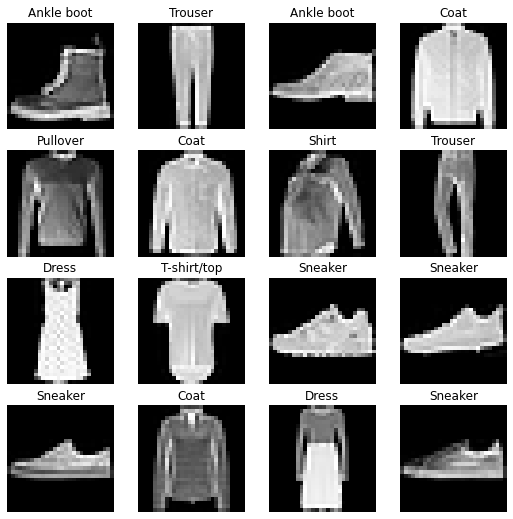

In [59]:
train_data = datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
class_names = train_data.classes

print("Classes:", class_names)
print("Training Data", len(train_data), train_data[0][0].shape, train_data[0][1], )
print("Training Data", len(test_data), test_data[1][0].shape, test_data[1][1])

rows, cols = 4, 4
fig = plt.figure(figsize=(9, 9))

for i in range(1, (rows*cols) + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label]);
    plt.axis(False);

## Data Loading and Preparation

We use PyTorch's DataLoader to efficiently batch and load our data:

In [60]:
BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [61]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X,y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [62]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [63]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [64]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


## Model Architectures

### Model 0: Simple Linear Network

In [65]:
class FashionModel0(nn.Module):

    def __init__(self, in_features, hidden_content, out_features):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden_content),
            nn.Linear(in_features=hidden_content, out_features=out_features),
        )

    def forward(self, x):
        return self.layers_stack(x)

model_0 = FashionModel0(784, 10, len(class_names)).to(device)
model_0

FashionModel0(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

Key Features:

- Simple architecture with two linear layers
- No activation functions
- Input flattened from 28x28 to 784 features
- Achieves ~83% accuracy

In [66]:
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

from torchmetrics import Accuracy

# accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)
from helper_functions import accuracy_fn

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 0.72346 | Train accuracy: 74.98%
Test loss: 0.53882 | Test accuracy: 81.46%

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 0.50446 | Train accuracy: 82.30%
Test loss: 0.49525 | Test accuracy: 82.63%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 0.47025 | Train accuracy: 83.48%
Test loss: 0.47867 | Test accuracy: 83.24%

Train time on cuda: 14.287 seconds


{'model_name': 'FashionModel0',
 'model_loss': 0.47867122292518616,
 'model_acc': 83.23773734177215}

### Model 1: Linear Network with ReLU

In [67]:
class FashionModel1(nn.Module):

    def __init__(self, in_features, hidden_content, out_features):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden_content),
            nn.ReLU(),
            nn.Linear(in_features=hidden_content, out_features=out_features),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers_stack(x)

model_1 = FashionModel1(784, 10, len(class_names)).to(device)
model_1

FashionModel1(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

Key Features:

- Added ReLU activation functions
- Same basic structure as Model 0
- Surprisingly performed worse (~55% accuracy)
- Shows that more complexity doesn't always mean better results

In [68]:
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
from helper_functions import accuracy_fn

from torchmetrics import Accuracy

# accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_1_results

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 1.51712 | Train accuracy: 50.51%
Test loss: 1.33187 | Test accuracy: 54.60%

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 1.29688 | Train accuracy: 55.14%
Test loss: 1.28379 | Test accuracy: 55.32%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 1.26161 | Train accuracy: 55.58%
Test loss: 1.26655 | Test accuracy: 55.52%

Train time on cuda: 14.493 seconds


{'model_name': 'FashionModel1',
 'model_loss': 1.2665472030639648,
 'model_acc': 55.51819620253165}

### Model 2: Convolutional Neural Network

In [69]:
class FashionModel2(nn.Module):

    def __init__(self, in_features, hidden_content, out_features):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_features, 
                      out_channels=hidden_content, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_content, 
                      out_channels=hidden_content,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_content, hidden_content, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_content, hidden_content, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_content*7*7, 
                      out_features=out_features)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


model_2 = FashionModel2(1, 25, len(class_names)).to(device)
model_2

FashionModel2(
  (block_1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1225, out_features=10, bias=True)
  )
)

Key Features:

- Convolutional layers to learn spatial features
- Two conv blocks with MaxPooling
- Final linear classifier
- Achieves ~85% accuracy
- Uses Adam optimizer instead of SGD

In [70]:
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.02)
from helper_functions import accuracy_fn

from torchmetrics import Accuracy

# accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
        
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

model_2_results = eval_model(model=model_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_2_results

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 0.62300 | Train accuracy: 77.52%
Test loss: 0.43396 | Test accuracy: 84.21%

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 0.41702 | Train accuracy: 84.82%
Test loss: 0.43090 | Test accuracy: 84.70%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 51200/60000 samples
Train loss: 0.39390 | Train accuracy: 85.70%
Test loss: 0.40673 | Test accuracy: 85.63%

Train time on cuda: 17.068 seconds


{'model_name': 'FashionModel2',
 'model_loss': 0.40672945976257324,
 'model_acc': 85.6309335443038}

## Results Comparison

      model_name  model_loss  model_acc  training_time
0  FashionModel0    0.478671  83.237737      14.286503
1  FashionModel1    1.266547  55.518196      14.492880
2  FashionModel2    0.406729  85.630934      17.067521


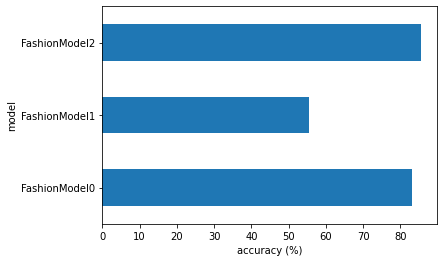

In [71]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
print(compare_results)

compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

**Key Insights**

1. CNN Superiority: The CNN model (Model 2) performed best, demonstrating the value of convolutional layers for image processing.
2. Activation Function Impact: Adding ReLU to the linear model (Model 1) actually decreased performance, showing that architectural changes need careful consideration.
3. Optimizer Choice: Switching from SGD to Adam in Model 2 helped achieve better results.
4. Training Time: The CNN took slightly longer to train but provided better results, showing a good trade-off between computational cost and performance.

## Model Evaluation

We evaluated our models using:
1. Overall accuracy metrics
2. Confusion matrix visualization
3. Individual prediction visualization on sample images

In [72]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [73]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


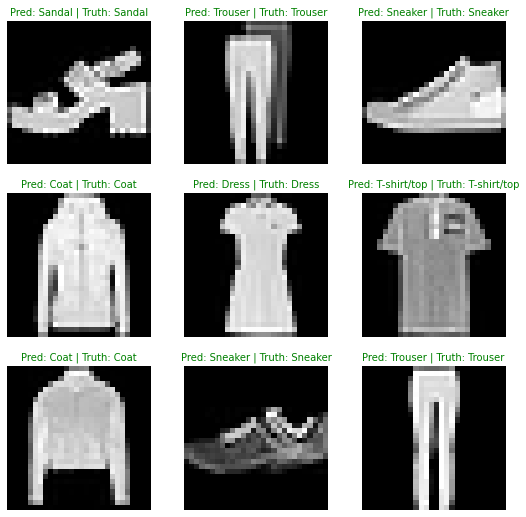

In [74]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [75]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/79 [00:00<?, ?it/s]

In [76]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


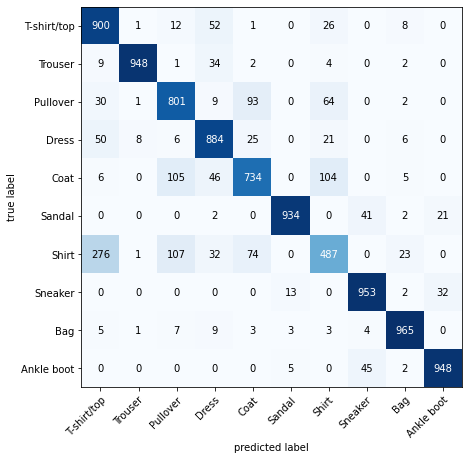

In [77]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## Conclusion

This project demonstrates the evolution from simple linear models to CNNs for image classification. While the basic linear model performed surprisingly well, the CNN architecture proved superior for this task. This shows that while deep learning has powerful capabilities, simpler models shouldn't be overlooked as they can provide decent baselines with less complexity.
The confusion matrix reveals common misclassifications between similar items (like shirts and t-shirts), highlighting the challenges in distinguishing between visually similar categories.

## Possible Improvements

- Train for more epochs
- Implement data augmentation
- Try deeper architectures
- Add batch normalization
- Experiment with different optimizers and learning rates
- Implement learning rate scheduling